In [1]:
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

In [2]:
%cd /mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization/

/mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization


/home/emmt/anaconda3/envs/workshop/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%autoreload 
from code_lib.Forward import *
from code_lib.Training import *

In [4]:
def init_params(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))    
    # key, subkey = jx.random.split(key)
    # bs.append(jx.random.normal(subkey, (layers[i + 1],))*std_glorot)
  return [Ws, bs]


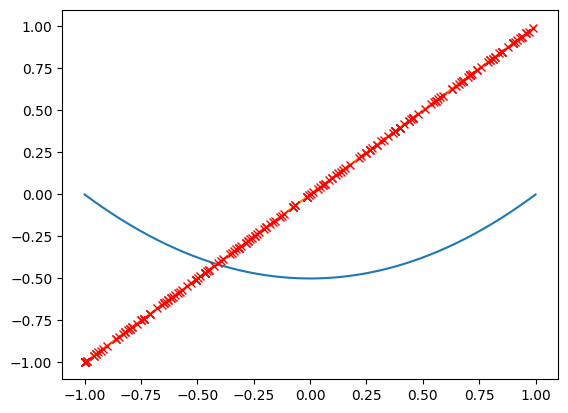

In [18]:
X = np.linspace(-1, 1, 200)[:, None]
# Y = 1/(X**2-1.1)#np.cos(8.*X*np.pi)*np.exp(-8*X)
# Y /= Y.max()
# Y = np.sin(5*X)
# X0 = 0.2
# intY = np.sin(5*X)
# Y = 5*np.cos(5*X)
# intY = np.linalg.norm(X-X0, axis=1)
# Y = (X<X0)*-1+(X>=X0)*1
# intY = X*0+1
# Y = X*0
intY = 0.5*X**2 - 0.5
Y = X
dY = 1+X*0

# intY = 0.2*X**4 +X**2
# Y = 0.8*X**3+2*X
# dY = 2.4*X**2+2


# intY = np.cos(X*2*np.pi)-1
# Y = -2*np.pi*np.sin(X*2*np.pi)
# dY = -4*np.pi**2*np.cos(X*2*np.pi)

rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 200)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.plot(X, intY)
plt.plot(X, Y)
plt.plot(X_train, Y_train, "rx")
plt.show()

In [19]:
def init_params_modi(layers, key):
  # Equisdi initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    # Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    # W = jx.random.normal(subkey, (layers[i], layers[i + 1]))+1
    W = np.ones((layers[i], layers[i + 1]))
    # W = np.array(W)
    W[::2,::2]*=-1

    Ws.append(W)  
    bs.append(-W[0]*c)
  return [Ws, bs]


def plt_state_1d(params, lbl):
  pass
  # W0, b0 = params
  # W0 = W0[0]
  # b0 = b0[0]
  # plt.plot(X, Y)
  # plt.plot(X, forward_pass(X, params), label=lbl)
  # # plt.plot(X_train, Y_train, "rx")
  # plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  # plt.xlim(-1, 1)
  # plt.legend()
  # plt.show()

  # plt.plot(X, jx.nn.relu(X@W0+b0)**2)
  # plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  # plt.xlim(-1, 1)
  # plt.show()

In [21]:
layers = [1] + [32]*1 + [1]
bsize = 64
nIter = 1000
lr = 1e-3
stop_at = 1e-20
trainer = Training(optimizers.adam, {"lr":lr})

key = jx.random.PRNGKey(0)

X_c = jnp.array([[-1,1]]).T
@jx.jit
def loss(params, X, Y, X_c):
    # g = forward_grad_pass(X, params)
    g2 = forward_grad2_pass(X, params)
    obj = -4*jnp.pi**2*jnp.cos(X*2*jnp.pi)*0+1
    y = forward_pass(X_c, params)

    # MSE =jnp.mean((g-Y)**2) #+ jnp.mean((y)**2)*1e-2
    MSE =jnp.mean((g2-obj)**2) + jnp.mean(y**2)
    return  MSE

@jx.jit
def loss_2(s, layer_output, g_layer_output, g2_layer_output, X, Y):
    Yint_pred = layer_output@s
    Y_pred = g_layer_output@s
    dY_pred = g2_layer_output@s
    obj = -4*jnp.pi**2*jnp.cos(X*2*jnp.pi)*0+1
    # MSE = jnp.mean((Y_pred[:,None]-Y)**2)
    MSE = jnp.mean((dY_pred[:,None]-obj)**2)
    MSE += jnp.mean((Yint_pred[:,None])**2)#*1e-2
    return  MSE


params_glorot = init_params(layers, key)
opt_state = trainer.opt_init(params_glorot)

plt_state_1d(params_glorot, "iter_0")
params_glorot, train_loss, val_loss = trainer.train_ls_auto(loss, loss_2, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)

plt_state_1d(params_glorot, f"iter_{nIter}")

#modified init

params = init_params_modi(layers, key)
opt_state = trainer.opt_init(params)

plt_state_1d(params, "iter_0")
params, train_loss2, val_loss2 = trainer.train_ls_auto(loss, loss_2, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)

plt_state_1d(params, f"iter_{nIter}")

it 950, train loss = 9.453841e-03: 100%|████████████████████████████████████████████| 1000/1000 [00:22<00:00, 45.31it/s]


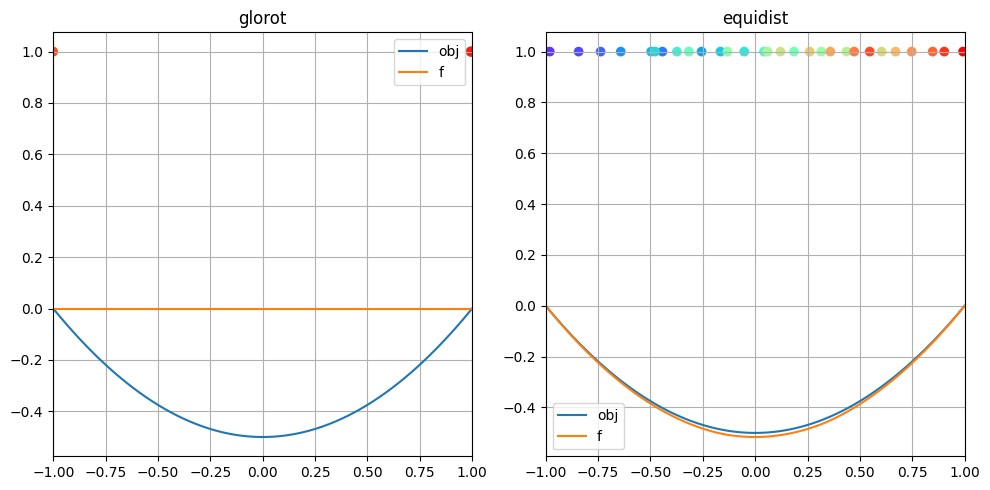

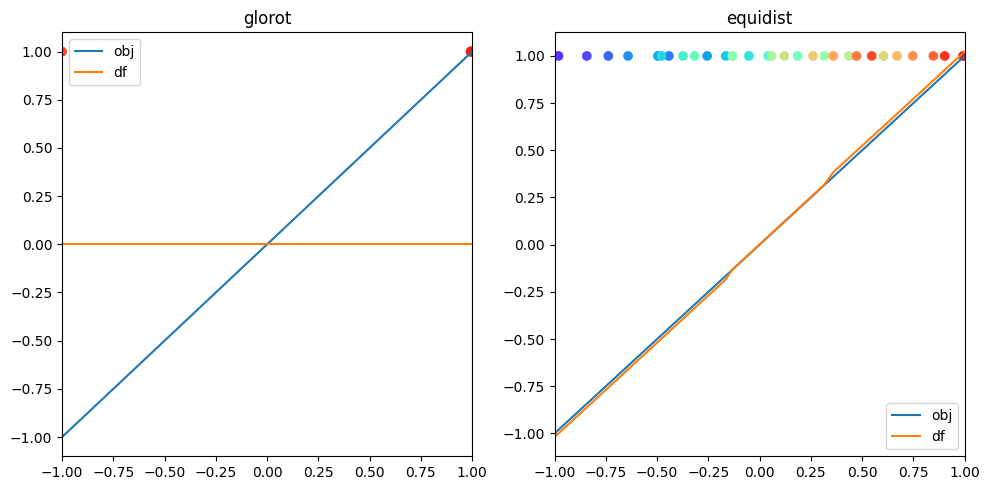

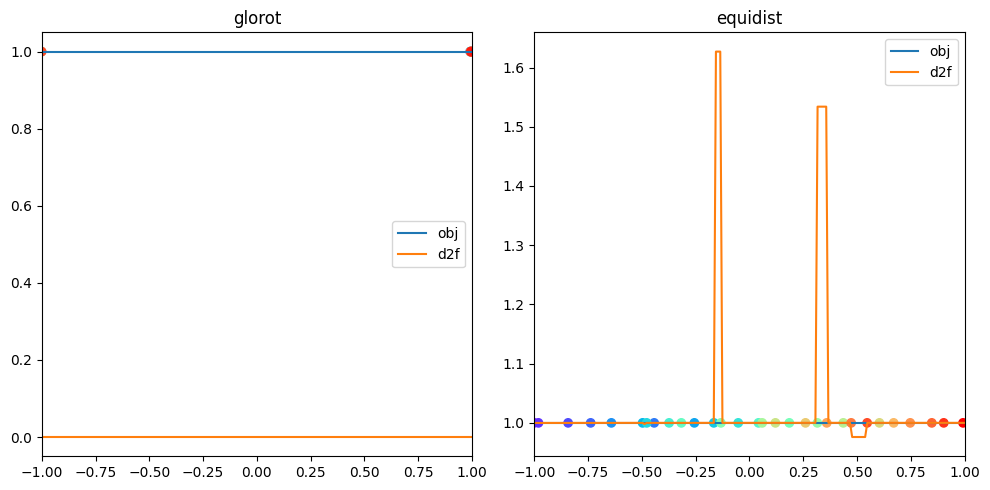

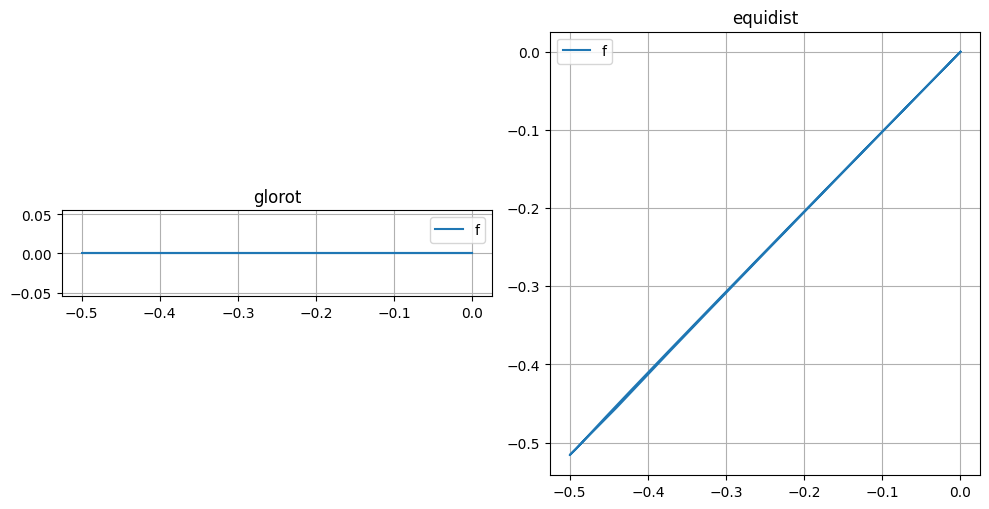

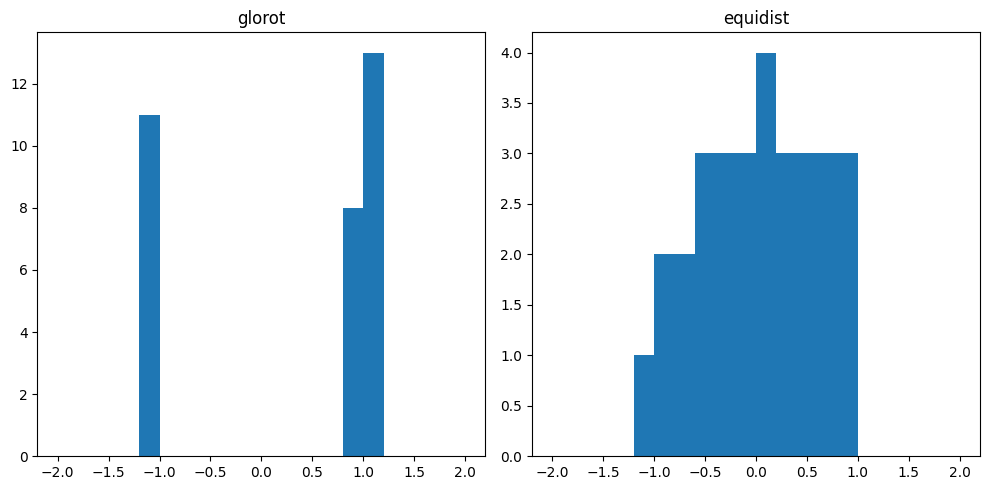

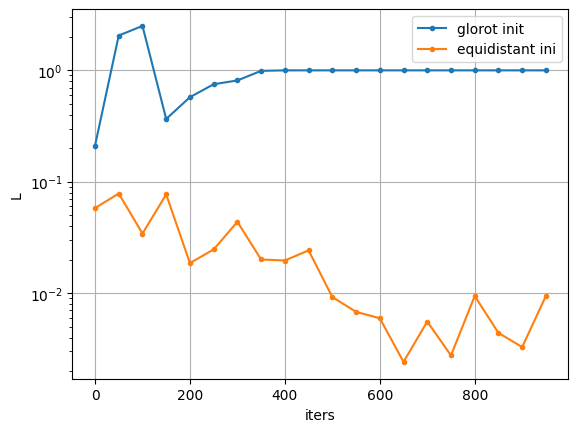

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, intY, label="obj")
ax[0].plot(X, forward_pass(X, params_glorot)-forward_pass(X, params_glorot)[0], label="f")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, intY, label="obj")
ax[1].plot(X, forward_pass(X, params)-forward_pass(X, params)[0], label="f")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
ax[0].grid();ax[1].grid()
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, Y, label="obj")
ax[0].plot(X, forward_grad_pass(X, params_glorot), label="df")
# ax[0].plot(X_train, Y_train, "rx")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, Y, label="obj")
ax[1].plot(X, forward_grad_pass(X, params), label="df")
# ax[1].plot(X_train, Y_train, "rx")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
fig.tight_layout()
plt.show()


fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, dY, label="obj")
ax[0].plot(X, forward_grad2_pass(X, params_glorot), label="d2f")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, dY, label="obj")
ax[1].plot(X, forward_grad2_pass(X, params), label="d2f")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
# ax[1].set_ylim(dY.mean()-0.5, dY.mean()+0.5)
# ax[0].set_ylim(dY.mean()-0.5, dY.mean()+0.5)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
ax[0].plot(intY, forward_pass(X, params_glorot), label="f")
ax[0].legend()
ax[1].plot(intY, forward_pass(X, params), label="f")
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
ax[0].axis("scaled");ax[1].axis("scaled")
ax[0].grid();ax[1].grid()
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].hist(-b0/W0[0], bins=np.linspace(-2,2,21))
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].hist(-b0/W0[0], bins=np.linspace(-2,2,21))
ax[0].set_title("glorot")
ax[1].set_title("equidist")
fig.tight_layout()
plt.show()

plt.semilogy()
plt.plot(np.arange(len(train_loss))*50, train_loss, ".-", label="glorot init")
plt.plot(np.arange(len(train_loss2))*50, train_loss2, ".-", label="equidistant ini")
plt.ylabel("L")
plt.xlabel("iters")
plt.legend()
plt.grid()
plt.show()